# Implementation de la couche de convolution

Dans ce cours, nous allons implémenter une couche de convolution 1D. Dans le cours expliquant les couches de convolutions, nous avons parlé exclusivement de la convolution 2D car c'est cette couche qui est la plus utilisée (de loin). Cependant, pour bien comprendre le code et l'ingéniosité des couches de convolution, il est essentiel de commencer par la convolution 1D.

## Convolution 1D, comment ça marche ? 

De manière assez évidente, la convolution 1D est similaire à la convolution 2D mais sur une seule dimension. C'est lors de l'application de la couche de convolution 1D que l'on voit très rapidement pourquoi une couche de convolution est en fait une boucle *for*.   

<img src="images/conv1d.png" alt="conv1d" width="800"/>

Figure extraite du [forum](https://ai.stackexchange.com/questions/28767/what-does-channel-mean-in-the-case-of-an-1d-convolution).

Les paramètres classiques de la convolution 2D s'applique également : 
- Le *padding* va ajouter des valeurs au bord du vecteur 1D (début et fin)
- Le *stride* définit le pas 
- La *kernel_size* définit la taille du filtre
- Les *in_channels* et *out_channels* qui correspondent aux nombres de channels d'entrée et de sortie.
- etc ...

## Implémentation

Passons maintenant à l'implémentation de la couche de convolution 1D.

**Note** : Sur pytorch, les couches de convolutions ne sont pas implémentées en python mais en C++ pour une plus grande rapidité de calcul.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Dans une couche de convolution, on a une dimension de filtre *kernel_size* et un nombre de filtre *out_channels*. L'idée va être de boucler sur l'ensemble de notre vecteur et de calculer les valeurs de sortie en appliquant chaque filtre à chaque position possible du vecteur d'entrée. A chaque position, on va appliquer une couche fully connected prenant en entrée les éléments contenus dans le filtre de taille $(KernelSize \times InChannels)$ et renvoyant $OutChannels$ éléments. C'est comme si on appliquait une boucle *for* sur chaque position de notre séquence d'entrée.

**Note** : Sur la figure explicative, il n'y a qu'une seule dimension de channel mais en réalité il y en a plusieurs la plupart du temps.

In [14]:
in_channels = 3
out_channels = 16
kernel_size = 3
kernel=nn.Linear(in_channels*kernel_size, out_channels)

Maintenant, il faut appliquer cette couche de convolution sur l'ensemble des éléments de notre séquence avec un pas *stride*. On peut également ajouter du *padding* si on veut que la séquence d'entrée soit de la même taille que la séquence de sortie.

In [21]:
# Imaginons une séquence de 100 éléments, avec 3 canaux et un batch de 8
dummy_input = torch.randn(8, in_channels, 100)
print("Dimension de l'entrée: ",dummy_input.shape)
stride=1
padding=1
outs=[]

# On pad les deux côtés de l'entrée pour éviter les problèmes de dimensions
dummy_input=F.pad(dummy_input, (padding, padding))

for i in range(kernel_size,dummy_input.shape[2]+1,stride):
  chunk=dummy_input[:,:,i-kernel_size:i]
  # On redimensionne pour la couche fully connected
  chunk=chunk.reshape(dummy_input.shape[0],-1)
  # On applique la couche fully connected
  out=kernel(chunk)
  # On ajoute à la liste des sorties
  outs.append(out)
# On convertit la liste en un tenseur
outs=torch.stack(outs, dim=2)
print("Dimension de la sortie: ",outs.shape)

Dimension de l'entrée:  torch.Size([8, 3, 100])
Dimension de la sortie:  torch.Size([8, 16, 100])


Comme pour les convolutions 2D, on peut choisir de diminuer la taille de la séquence (ou des *feature map* si on parle d'une conv 2D). Pour cela, on peut utiliser un stride supérieur à 1 ou bien une couche de pooling.   

En pratique, l'utilisation du stride est souvent préférée mais nous allons implémenter le *max pooling* pour bien comprendre son fonctionnement.

In [27]:
pooling=2
outs2=[]
for i in range(pooling,outs.shape[2]+1,pooling):
  # On prend les éléments entre i-pooling et i
  chunk=outs[:,:,i-pooling:i]
  # On prend le max sur la dimension 2, pour le average pooling on aurait utilisé torch.mean
  out2=torch.max(chunk, dim=2)[0]
  outs2.append(out2)
# On convertit la liste en un tenseur 
outs2=torch.stack(outs2, dim=2)
print("Dimension de la sortie après pooling: ",outs2.shape)

Dimension de la sortie après pooling:  torch.Size([8, 16, 50])


Maintenant que nous avons compris comment la convolution 1D et le *maxpooling* fonctionnent, on va créer des classes pour faciliter leurs utilisations.

In [29]:
class Conv1D(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
    super(Conv1D, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.kernel_width = kernel_size
    self.kernel = nn.Linear(kernel_size * in_channels, out_channels)
    self.padding=padding

  def forward(self, x):
    x=F.pad(x, (self.padding, self.padding))
    # Boucle en une seule ligne pour un code plus concis
    l = [self.kernel(x[:, :, i - self.kernel_width: i].reshape(x.shape[0], self.in_channels * self.kernel_width)) for i in range(self.kernel_width, x.shape[2]+1, self.stride)]
    return torch.stack(l, dim=2)


class MaxPool1D(nn.Module):
  def __init__(self, pooling):
    super(MaxPool1D, self).__init__()
    self.pooling = pooling
    
  def forward(self, x):
    # Boucle en une seule ligne pour un code plus concis
    l = [torch.max(x[:, :, i - self.pooling: i], dim=2)[0] for i in range(self.pooling, x.shape[2]+1, self.pooling)]
    return torch.stack(l, dim=2)

## Cas pratique : MNIST

Maintenant que l'on a implémenté nos couches de convolutions et de pooling, nous allons les tester sur MNIST. Sur MNIST, on traite des images, il est donc plus logique d'utiliser des convolutions 2D en pratique (cf cours suivant).   
Ici, nous allons juste vérifier que notre implémentation des convolutions fonctionne :

In [38]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Dataset

In [39]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

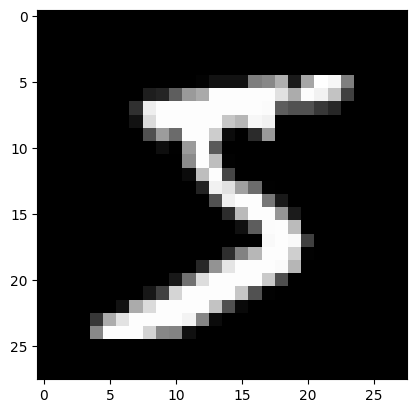

Le chiffre sur l'image est un 0


In [40]:
plt.imshow(dataset[0][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[1][1]))

In [41]:
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

On peut maintenant créer notre modèle. Notons que l'on utilise un *stride* de 2 et pas de *maxpooling* pour gagner du temps sur le traitement. 

In [49]:
class cnn1d(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=Conv1D(1,8,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 8 filtres
    self.conv2=Conv1D(8,16,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 16 filtres
    self.conv3=Conv1D(16,32,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 32 filtres
    self.fc=nn.Linear(3136,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,x.shape[1]*x.shape[2]) # Pour convertir la feature map de taille CxL en vecteur 1D (avec une dimension batch)
    output=self.fc(x)
    return output
dummy_input=torch.randn(8,1,784)
model=cnn1d()
output=model(dummy_input)
print(output.shape)

print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

torch.Size([8, 10])
Nombre de paramètres 33370


Le modèle a presque 10 fois moins de paramètres que notre modèle fully connected du cours précédent ! 

In [50]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [51]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    images=images.view(images.shape[0],1,784)
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      images=images.view(images.shape[0],1,784)
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.4011246860027313
step 0 val loss 0.2103319615125656
step 1 train loss 0.17427290976047516
step 1 val loss 0.1769915670156479
step 2 train loss 0.14464063942432404
step 2 val loss 0.14992524683475494
step 3 train loss 0.12802869081497192
step 3 val loss 0.13225941359996796
step 4 train loss 0.11609579622745514
step 4 val loss 0.12663421034812927


In [53]:
correct = 0
total = 0
for images,labels in test_loader:
  images=images.view(images.shape[0],1,784) 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  96.35


On obtient une très bonne précision bien que légérement inférieure à celle obtenue avec le réseau fully connected du cours précédent. 

**Note** : L'entraînement était assez lent, c'est à cause de notre implémentation qui n'est pas très efficace, l'implémentation pytorch en C++ est beaucoup plus performante.

**Note 2** : Nous avons utilisé des convolutions 1D pour traîter des images ce qui n'est pas optimal. L'idéal est d'utiliser des convolutions 2D.

## Bonus : Conv2D

On peut implémenter la convolution 2D en suivant le même principe mais en deux dimensions : 

In [15]:
in_channels = 3
out_channels = 16
kernel_size = 3
# On a un kernel de taille 3x3 car on est en 2D
kernel=nn.Linear(in_channels*kernel_size**2, out_channels)

In [16]:
# Pour une image de taille 10x10 avec 3 canaux et un batch de 8
dummy_input = torch.randn(8, in_channels, 10,10)
b, c, h, w = dummy_input.shape
print("Dimension de l'entrée: ",dummy_input.shape)
stride=1
padding=1
outs=[]

# Le padding change pour une image 2D, on doit pad en hauteur et en largeur
dummy_input=F.pad(dummy_input, (padding, padding,padding,padding))
print("Dimension de l'entrée après padding: ",dummy_input.shape)

# On boucle sur les dimensions de l'image : W x H 
for i in range(kernel_size,dummy_input.shape[2]+1,stride):
  for j in range(kernel_size,dummy_input.shape[3]+1,stride):
    chunk=dummy_input[:,:,i-kernel_size:i,j-kernel_size:j]
    # On redimensionne pour la couche fully connected
    chunk=chunk.reshape(dummy_input.shape[0],-1)
    # On applique la couche fully connected
    out=kernel(chunk)
    # On ajoute à la liste des sorties
    outs.append(out)
# On convertit la liste en un tenseur
outs=torch.stack(outs, dim=2)
outs=outs.reshape(b,out_channels,h, w)
print("Dimension de la sortie: ",outs.shape)

Dimension de l'entrée:  torch.Size([8, 3, 10, 10])
Dimension de l'entrée après padding:  torch.Size([8, 3, 12, 12])
Dimension de la sortie:  torch.Size([8, 16, 10, 10])


On peut le faire en classe maintenant comme pour la conv1D : 

In [34]:
class Conv2D(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
    super(Conv2D, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.kernel_width = kernel_size
    self.kernel = nn.Linear(in_channels*kernel_size**2 , out_channels)
    self.padding=padding

  def forward(self, x):
    b, c, h, w = x.shape
    x=F.pad(x, (self.padding, self.padding,self.padding,self.padding))
    # Sur une seule ligne, c'est absolument illisible, on garde la boucle
    l=[]
    for i in range(self.kernel_width, x.shape[2]+1, self.stride):
      for j in range(self.kernel_width, x.shape[3]+1, self.stride):
        chunk=self.kernel(x[:,:,i-self.kernel_width:i,j-self.kernel_width:j].reshape(x.shape[0],-1))
        l.append(chunk)
    # La version en une ligne, pour les curieux
    #l = [self.kernel(x[:, :, i - self.kernel_width: i, j - self.kernel_width: j].reshape(x.shape[0], ,-1)) for i in range(self.kernel_width, x.shape[2]+1, self.stride) for j in range(self.kernel_width, x.shape[3]+1, self.stride)]
    outs=torch.stack(l, dim=2)
    return outs.reshape(b,self.out_channels,h//self.stride, w//self.stride)

dummy_input=torch.randn(8,3,32,32)
model=Conv2D(3,16,stride=2,kernel_size=3,padding=1)
output=model(dummy_input)
print(output.shape)

torch.Size([8, 16, 16, 16])


On peut maintenant créer notre modèle :

In [50]:
class cnn2d(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=Conv2D(1,8,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 8 filtres
    self.conv2=Conv2D(8,16,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 16 filtres
    self.conv3=Conv2D(16,32,kernel_size=3,stride=1,padding=1) # Couche de convolution 1D de 32 filtres
    self.fc=nn.Linear(1568,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]) # Pour convertir la feature map de taille CxL en vecteur 1D (avec une dimension batch)
    output=self.fc(x)
    return output
dummy_input=torch.randn(8,1,28,28)
model=cnn2d()
output=model(dummy_input)
print(output.shape)

print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

torch.Size([8, 10])
Nombre de paramètres 21578


On peut maintenant entrainer notre modèle sur MNIST et regarder si on a des meilleurs résultats qu'avec les convolutions 1D.

In [51]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [52]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.36240848898887634
step 0 val loss 0.14743468165397644
step 1 train loss 0.1063414067029953
step 1 val loss 0.1019362062215805
step 2 train loss 0.07034476101398468
step 2 val loss 0.08669546991586685
step 3 train loss 0.05517915263772011
step 3 val loss 0.07208992540836334
step 4 train loss 0.04452721029520035
step 4 val loss 0.0664198026061058


En terme de loss, on est descendu plus bas que pour notre modèle avec les convolutions 1D.

In [53]:
correct = 0
total = 0
for images,labels in test_loader:
  with torch.no_grad():
    preds=model(images)
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  98.23


La précision est très bonne ! C'est mieux que ce que nous avions avec les [réseaux fully connected](../02_RéseauFullyConnected/03_TechniquesAvancées.ipynb) alors que l'on a 10 fois moins de paramètres.

**Note** : De la même manière, on peut implémenter des convolutions 3D qui peuvent être utilisées pour le traitement des vidéos (l'axe temporel est rajouté).